### Atributos

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, 
containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



In [133]:
import numpy as np
import pandas as pd
from scipy import cluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import matplotlib.dates as dates

In [134]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [135]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [137]:
df.shape

(2075259, 7)

In [138]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [139]:
# pegando os valores q eu preciso
X = df.head(50).iloc[:, 0:7].values

In [140]:
# preenchendo as células que contém nan com a média
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [141]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [142]:
# Convenience method for frequency conversion and resampling of time series.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
df['Global_active_power'].resample('M').sum()

dt
2006-12-31    41817.648460
2007-01-31    69014.045230
2007-02-28    56491.069230
2007-03-31    58863.283615
2007-04-30    39245.548781
2007-05-31    44008.872000
2007-06-30    35729.767447
2007-07-31    29846.831570
2007-08-31    34120.475531
2007-09-30    41874.789230
2007-10-31    49278.553230
2007-11-30    55920.827230
2007-12-31    72605.261615
2008-01-31    65170.473615
2008-02-29    49334.346845
2008-03-31    55591.685615
2008-04-30    48209.992000
2008-05-31    45724.043230
2008-06-30    42945.063615
2008-07-31    35479.601230
2008-08-31    12344.063230
2008-09-30    42667.792000
2008-10-31    50743.399447
2008-11-30    59918.584535
2008-12-31    56911.416668
2009-01-31    62951.099615
2009-02-28    50291.953362
2009-03-31    54761.169230
2009-04-30    49277.707230
2009-05-31    45214.196460
2009-06-30    37149.767696
2009-07-31    27594.810460
2009-08-31    30049.032998
2009-09-30    42631.838845
2009-10-31    51089.811615
2009-11-30    55068.733615
2009-12-31    60907.18923

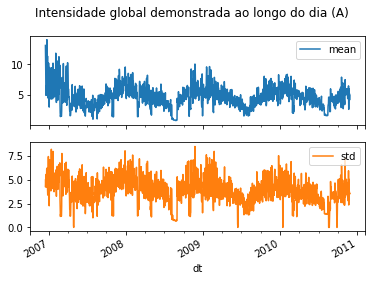

In [143]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Intensidade global demonstrada ao longo do dia (A)')
plt.show()

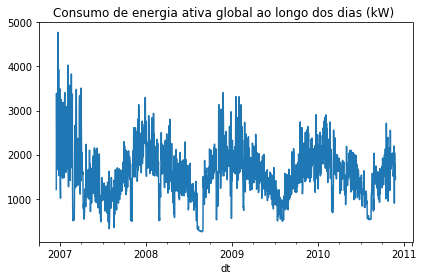

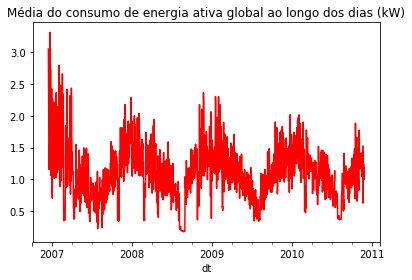

In [144]:
df.Global_active_power.resample('D').sum().plot(title='Consumo de energia ativa global ao longo dos dias (kW) ') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Média do consumo de energia ativa global ao longo dos dias (kW)', color='red') 
plt.tight_layout()
plt.show()

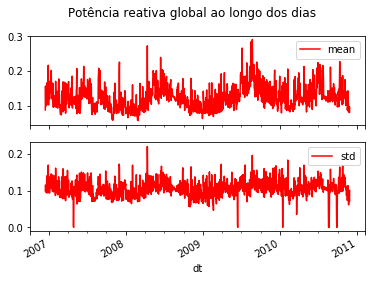

In [145]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Potência reativa global ao longo dos dias', color='red')
plt.show()

In [146]:
df.loc['2007-02-01'].head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2007-02-01 00:00:00,0.326,0.128,243.15,1.4,0.0,0.0,0.0
2007-02-01 00:01:00,0.326,0.130,243.32,1.4,0.0,0.0,0.0
2007-02-01 00:02:00,0.324,0.132,243.51,1.4,0.0,0.0,0.0
2007-02-01 00:03:00,0.324,0.134,243.90,1.4,0.0,0.0,0.0
2007-02-01 00:04:00,0.322,0.130,243.16,1.4,0.0,0.0,0.0


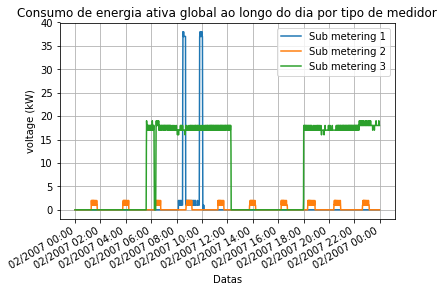

In [147]:
fig, ax = plt.subplots()
ax.plot(df.loc['2007-02-01'].index, df.loc['2007-02-01']['Sub_metering_1'], label='Sub metering 1')
ax.plot(df.loc['2007-02-01'].index, df.loc['2007-02-01']['Sub_metering_2'], label='Sub metering 2')
ax.plot(df.loc['2007-02-01'].index, df.loc['2007-02-01']['Sub_metering_3'], label='Sub metering 3')
ax.set(xlabel='Datas', ylabel='voltage (kW)',
       title='Consumo de energia ativa global ao longo do dia por tipo de medidor')
ax.grid()
ax.set_xticks(df.loc['2007-02-01'].index)
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%m/%Y %H:%M'))
plt.gca().xaxis.set_major_locator(dates.HourLocator(byhour=range(0,24,2)))
plt.gcf().autofmt_xdate()
plt.legend(loc='upper right')
plt.show()

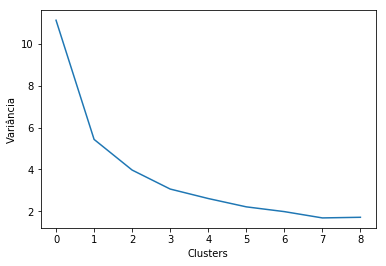

In [148]:
# using Elbow Method

initial = [cluster.vq.kmeans(X,i) for i in range(1,10)]
plt.plot([var for (cent,var) in initial])
plt.xlabel('Clusters')
plt.ylabel('Variância')
plt.show()

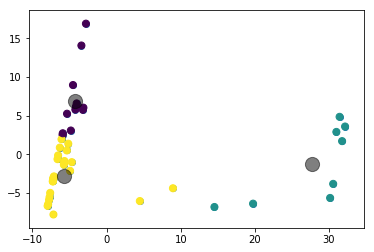

In [149]:
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1])
kmeans = KMeans(n_clusters=3, random_state=111)
kmeans.fit(pca_2d)
y_kmeans = kmeans.predict(pca_2d)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

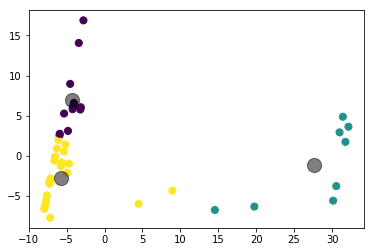

For n_clusters = 2 The average silhouette_score is : 0.7636881710686854


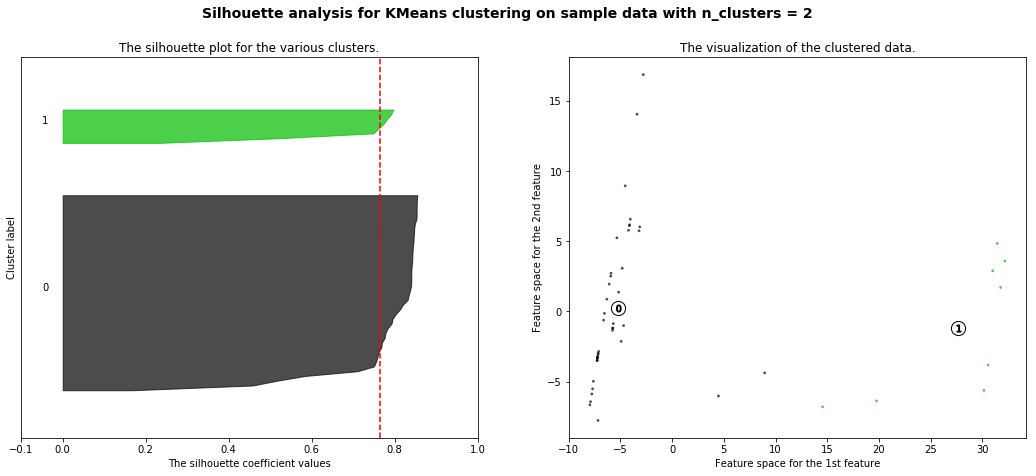

For n_clusters = 3 The average silhouette_score is : 0.5543535632345725


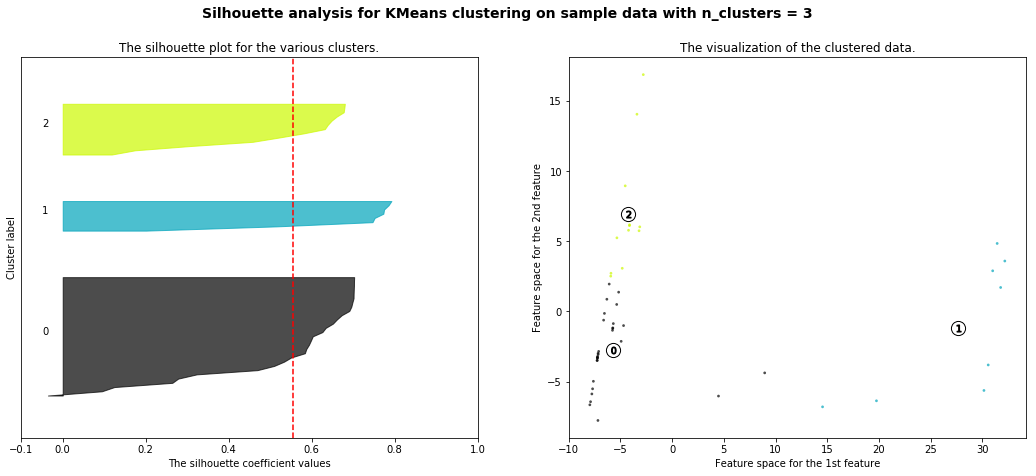

For n_clusters = 4 The average silhouette_score is : 0.5960683763059073


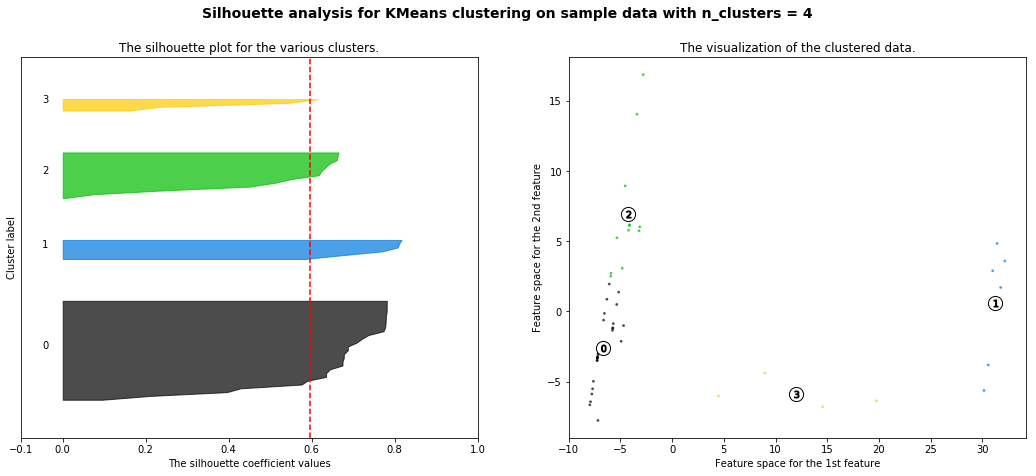

For n_clusters = 5 The average silhouette_score is : 0.5965627509529792


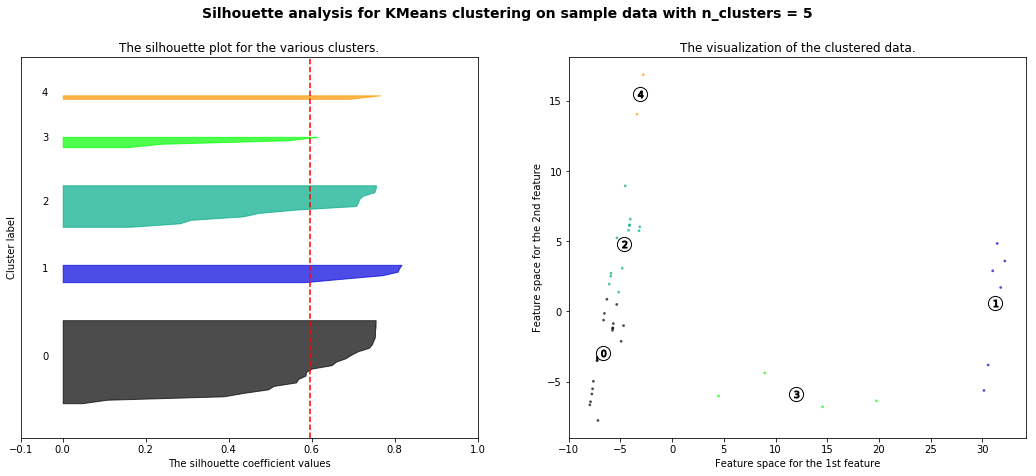

For n_clusters = 6 The average silhouette_score is : 0.587517063976713


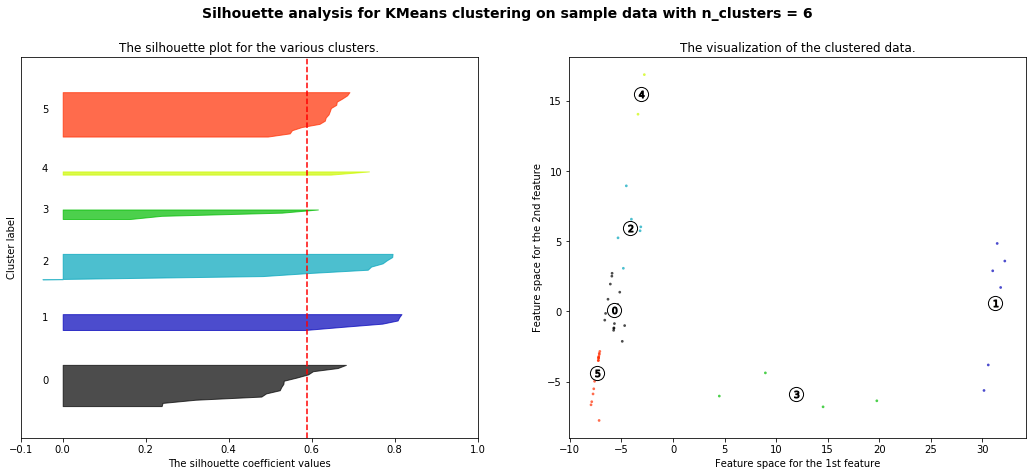

In [131]:
silhouette

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pca_2d) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pca_2d)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_2d, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_2d, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pca_2d[:, 0], pca_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()